# Case Study Data Science Master, Module 2 : Hate Speech Detection
Data Science Master 2022/2023, Prof. Dr. Gottfried Vossen, Student: Jan Hümmelink

## Task Definition
Your tasks:
1. Read the data set and perform some initial analysis.
2. Clean the data. Before you start doing so, think of what needs to be cleaned in such a
dataset. Make sure that the model you will produce generalizes to tweets not yet contained
in the dataset.
3. Train your model, maybe split the data into training and test first.
4. Predict the results on the test set using a suitable measure.
5. Deploy your program on a (simulated) Web page. To this end, look at what we did in
notebook M2E15; just setting up a toy environment will be enough.
6. Enter a couple of short newly invented tweets to verify that your model can handle it
properly.

## 1. Read the data set and perform some initial analysis

In [1]:
import numpy as np
import pandas as pd
import scipy.stats

In [2]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


There must be many more tweets containing no hate speech than the ones containing hate speech. So next plot the distribution of them.

In [4]:
train[["label"]].value_counts()

label
0        29720
1         2242
dtype: int64

In [5]:
import plotly.express as px

px.pie(values=train[["label"]].value_counts(), names=["no hate speech", "hate speech"], title="Percentage of tweets containing hate speech")

The dataset is clearly unbalanced. So just assuming that there is no hate speech at all would lead to an accuracy of 92.99%. This must be taken in account for the further steps.

It could also be interesting how many words the tweets usually have and if there is a difference between tweets classified as hate speech and tweets that are not.

In [6]:
train["wordcount"] = train.apply(lambda x: len(x["tweet"].split()), axis =1)
train[train["label"]==0]["wordcount"].describe()

count    29720.000000
mean        13.091252
std          5.510082
min          3.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         34.000000
Name: wordcount, dtype: float64

In [7]:
train[train["label"]==1]["wordcount"].describe()

count    2242.000000
mean       14.053078
std         4.950747
min         3.000000
25%        10.000000
50%        14.000000
75%        17.000000
max        30.000000
Name: wordcount, dtype: float64

In [8]:
px.histogram(train, x="wordcount")

## 2. Clean the data
Before you start doing so, think of what needs to be cleaned in such a
dataset. Make sure that the model you will produce generalizes to tweets not yet contained

In [9]:
# column id is not needed for analyzing the tweets
train = train.drop("id", axis = 1)
test = test.drop("id", axis=1)

# word count is also not needed anymore, only in train df
train = train.drop("wordcount", axis = 1)

In [10]:
train["tweet"].head(20)

0      @user when a father is dysfunctional and is s...
1     @user @user thanks for #lyft credit i can't us...
2                                   bihday your majesty
3     #model   i love u take with u all the time in ...
4                factsguide: society now    #motivation
5     [2/2] huge fan fare and big talking before the...
6      @user camping tomorrow @user @user @user @use...
7     the next school year is the year for exams.ð...
8     we won!!! love the land!!! #allin #cavs #champ...
9      @user @user welcome here !  i'm   it's so #gr...
10     â #ireland consumer price index (mom) climb...
11    we are so selfish. #orlando #standwithorlando ...
12    i get to see my daddy today!!   #80days #getti...
13    @user #cnn calls #michigan middle school 'buil...
14    no comment!  in #australia   #opkillingbay #se...
15    ouch...junior is angryð#got7 #junior #yugyo...
16    i am thankful for having a paner. #thankful #p...
17                               retweet if you 

Things that have to be cleaned:
* hashtag character can be removed
* '@user' can be removed completely
* remove multiple whitespaces
* everything that is not a text character, number or whitespace can be removed (hashtags, special chars, punctuation)
* remove stopwords
* lemmatize the words

In [11]:
# this must be executed to be able to use the lemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/jan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

stop = stopwords.words("english")
lemmatizer = WordNetLemmatizer()


def cleaning_tweets(tweet:str):
    tweet = tweet.replace("@user","")
    tweet = " ".join(tweet.split())
    tweet = tweet.lower()
    tweet = re.sub(r'[^a-z\s]','',tweet) # searches for everything that is not a character between a and z, and not a whitespace
    
    splitted_tweet = tweet.split()
    result = []
    for x in splitted_tweet:
        if x not in stop:
            result.append(lemmatizer.lemmatize(x)) # add the lemmatized word

    return " ".join(result)

train["tweet"] = train["tweet"].apply(cleaning_tweets)
train

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thanks lyft credit cant use cause dont offer w...
2,0,bihday majesty
3,0,model love u take u time ur
4,0,factsguide society motivation
...,...,...
31957,0,ate isz youuu
31958,0,see nina turner airwave trying wrap mantle gen...
31959,0,listening sad song monday morning otw work sad
31960,1,sikh temple vandalised calgary wso condemns act


## 3. Train your model
Maybe split the data into training and test first.

In [13]:
# oversample the tweets containing hate speech to get a balanced dataset
from sklearn.utils import resample
train_majority = train[train["label"]==0]
train_minority = train[train["label"]==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),
                                 random_state=123
                                 )
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

# split the dataset in train and test
# param stratify: keep the proportion of values in that set
x_train, x_test, y_train, y_test = train_test_split(train_upsampled["tweet"], train_upsampled["label"], test_size=0.3, stratify=train_upsampled["label"])

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier

pipeline_sgd = Pipeline([
    ('vect', CountVectorizer()), # transform text to a matrix of word counts
    ('tfidf',  TfidfTransformer()), # Apply TFIDF on the word counts
    ('nb', SGDClassifier()), # Classifier with using stochastic gradients to apply labels
])

In [16]:
model = pipeline_sgd.fit(x_train, y_train)
y_predict = model.predict(x_test)
from sklearn.metrics import f1_score, accuracy_score, recall_score

# printing the scores of the model
print(f1_score(y_test, y_predict), accuracy_score(y_test,y_predict), recall_score(y_test,y_predict))

0.9678914266799074 0.9673620457604307 0.9838492597577388


In [17]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm_data = confusion_matrix(y_test,y_predict, normalize="all")
cm_data


array([[0.47543742, 0.02456258],
       [0.00807537, 0.49192463]])

<AxesSubplot: xlabel='real labels', ylabel='predicted labels'>

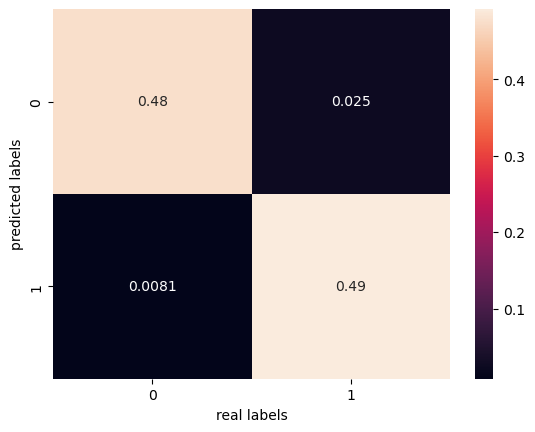

In [18]:
cm_plt = sn.heatmap(cm_data, annot=True)
cm_plt.set(xlabel="real labels", ylabel="predicted labels")
cm_plt

In [19]:
# calculate false negatives in relation to all positive records
cm_data[0,1]/(cm_data[1,1]+cm_data[0,1])

0.047557003257328985

In [20]:
# calculate false positives in relation to all negative records
cm_data[1,0]/(cm_data[0,0]+cm_data[1,0])

0.016701461377870562

In [21]:
import joblib
# save the model for the webapp
joblib.dump(model,"model.pkl")

['model.pkl']

## 4. Predict the results on the test set using a suitable measure.

In [22]:
predictions = model.predict(test["tweet"].apply(cleaning_tweets))
df_pred = pd.DataFrame({"tweets":test["tweet"],"label":predictions})
df_pred.head()

,tweets,label
0,#studiolife #aislife #requires #passion #dedic...,0
1,@user #white #supremacists want everyone to s...,1
2,safe ways to heal your #acne!! #altwaystohe...,0
3,is the hp and the cursed child book up for res...,0
4,"3rd #bihday to my amazing, hilarious #nephew...",0


In [23]:
df_pred.tail()

,tweets,label
17192,thought factory: left-right polarisation! #tru...,1
17193,feeling like a mermaid ð #hairflip #neverre...,0
17194,#hillary #campaigned today in #ohio((omg)) &am...,1
17195,"happy, at work conference: right mindset leads...",0
17196,"my song ""so glad"" free download! #shoegaze ...",0


In [24]:
import plotly.express as px

px.pie(values=df_pred[["label"]].value_counts(), names=["no hate speech", "hate speech"], title="Percentage of tweets containing hate speech")

## 5. Deploy your program on a (simulated) Web page. 
To this end, look at what we did in
notebook M2E15; just setting up a toy environment will be enough.

please have a look at task5.py.
To start the webapp please install streamlit and execute the following command in your terminal: 

*streamlit run task5.py*

## 6. Enter a couple of short newly invented tweets
 to verify that your model can handle it properly.

In [25]:
# disclaimer: the following tweets do not represent my opionion to these topics. They are just for validation purposes.
invented_tweets = ["Black people are the dumbest race i know",
                   "Really enjoyed the soccer game on sunday!",
                   "corona is an invention of the jews",
                   "i really like black cars, especially from Tesla #aesthetic #car"]
invented_tweets_df = pd.DataFrame({"tweet": invented_tweets})
invented_tweets_df["cleaned"] = invented_tweets_df["tweet"].apply(cleaning_tweets)
invented_tweets_df["pred"] = model.predict(invented_tweets_df["cleaned"])


invented_tweets_df

,tweet,cleaned,pred
0,Black people are the dumbest race i know,black people dumbest race know,1
1,Really enjoyed the soccer game on sunday!,really enjoyed soccer game sunday,0
2,corona is an invention of the jews,corona invention jew,1
3,"i really like black cars, especially from Tesl...",really like black car especially tesla aesthet...,0


We can see here, that in tweet 0 racism against people of color is classified correctly as hate speech, while in the context of cars the word black can be used without being classified as hate speech.